# 분류 시스템을 이용해서 자동으로 태그 달아주기
---
개념

    옷을 넣었을 때, 해당되는 카테고리/태그 출력해주기
    
카테고리란?

    무신사의 major/middle/minor 분류
    
태그란?

    사용자의 임의로 붙여진 #문자열
    
출력할 카테고리의 범위

1. 대분류 단위  
    장점 : 남녀간 형태차이가 확실한 옷은 잘 분류  
    단점 : 세부적인 추천이 불가능함. 티셔츠같은 경우는 남자 여자 구분이 쉽지않음
2. 중분류 단위  
    장점 : 가장 적절한 분류 카테고리  
    단점 : 무신사의 특성상, 중분류 밑에서도 옷의 종류가 굉장히 많이 차이남
3. 소분류 단위  
    장점 : 섬세한 추천이 가능  
    단점 : 카테고리 수가 매우 늘어나 난이도 상승,  
    같은 소분류라도 다른 대분류 하에 있을 수 있는데 이를 어떻게 처리하지
    
분류가 비교적 정확히 되는 속성 : color/shape  
분류가 비교적 정확히 되지 않는 속성 : texture/small pattern

## CNN-only
원리

    Classification 방식 도입
    
    train : 이미지-카테고리 데이터셋으로, CNN을 통해 지도학습시킴
    test : 새로운 옷이 들어온 경우 해당 모델에 집어넣고 나오는 카테고리를 사용
    model : 여기에서 사용된 모델이 추후 feature extraction에도 사용됨
    
제공할 데이터

    이미지(필수)

모델 접근법
1. 중->소 순으로 넘어가기      
    아무리 생각해도 one-for-all 모델은 존재하지 않음  
    특히 분류를 소분류단위로 할 경우는 더더욱  
    따라서, 중분류 단위로 모델을 만들고, 카테고리
  
2. **소분류로 한번에 분류하기**  
    남/녀 구분없이 그냥 소분류로 때려버리는것도 괜찮을듯  
    정확하게 소분류를 구분하지 못하더라도, 사용자에게 컨펌받아 수정하면 되니까!

Multi Category 분류 방법(Blue/T-shirt 등)  
https://github.com/KerasKorea/KEKOxTutorial/blob/master/35_케라스를%20이용한%20다중%20라벨%20분류.md
    


데이터 준비 - minor/숫자 매핑 (3중 조인으로 해결해서 필요없을줄 알았는데 one-hot encoding에 필요함)

In [1]:
#경로 설정용
import os

os.chdir('..')

In [2]:
#DB 연결
import json
import pymysql
import numpy as np
import pandas as pd

#데이터 url/fs 전처리용
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.utils import Sequence
from skimage.io import imread
from skimage.transform import resize

#이미지 배경 전처리용
import cv2

#모델 작성용
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications import resnet50, vgg16, vgg19, inception_resnet_v2,inception_v3, densenet
from tensorflow.keras.applications import mobilenet,mobilenet_v2, nasnet, xception
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D,GlobalAveragePooling2D, Dropout

In [3]:
def connect_db(dbinfo_path) :
    with open(dbinfo_path) as jsonfile :
        dbinfo = json.load(jsonfile)

    connection = pymysql.connect(host=dbinfo['host'],
                         port=dbinfo['port'],
                         user=dbinfo['user'], 
                         passwd=dbinfo['passwd'],
                         db=dbinfo['db'],
                         charset=dbinfo['charset'])
    
    return connection

In [4]:
db = connect_db('dbinfo-temp.json')

In [5]:
def get_train_minor(connection) :
    """
    DB로부터 학습용 minor 카테고리 정보 획득
    기능성 상/하의, 환절기 코트, 기타 브랜드, 웨이스트 백은 제외
    input : db connector
    output : db cursor
    """
    cur = connection.cursor()

    sql = 'SELECT MIN(id),minor FROM CLOTHES_CLASS \
    GROUP BY minor \
    HAVING minor != "기능성 상의" AND minor != "기능성 하의" AND minor != "웨이스트 백"\
    AND minor NOT LIKE "(%";'

    print("선택된 row 개수 : ",cur.execute(sql))
    return cur

In [6]:
cur = get_train_minor(db)

선택된 row 개수 :  40


In [7]:
minor_list = []
for index,minor in cur :
    minor_list.append([minor,index])

In [8]:
minor_array = np.array(minor_list)

In [9]:
minor_array

array([['겨울 기타 코트', '93'],
       ['겨울 싱글 코트', '91'],
       ['기타 바지', '122'],
       ['기타 상의', '70'],
       ['기타 아우터', '84'],
       ['긴팔 티셔츠', '54'],
       ['나일론/코치  재킷', '82'],
       ['니트/스웨터/카디건', '66'],
       ['데님 팬츠', '110'],
       ['레깅스', '120'],
       ['레더/라이더스 재킷', '74'],
       ['롱 스커트', '128'],
       ['롱 패딩/롱 헤비 아우터', '95'],
       ['맥시 원피스', '107'],
       ['맨투맨/스웨트셔츠', '62'],
       ['미니 스커트', '124'],
       ['미니 원피스', '104'],
       ['미디 스커트', '126'],
       ['미디 원피스', '106'],
       ['민소매 티셔츠', '56'],
       ['반팔 티셔츠', '52'],
       ['베스트', '68'],
       ['블루종/MA-1', '72'],
       ['사파리/헌팅 재킷', '101'],
       ['셔츠/블라우스', '58'],
       ['숏 패딩/숏 헤비 아우터', '97'],
       ['숏 팬츠', '118'],
       ['수트 팬츠/슬랙스', '113'],
       ['수트/블레이저 재킷', '78'],
       ['스타디움 재킷', '87'],
       ['아노락 재킷', '80'],
       ['점프수트', '108'],
       ['코튼 팬츠', '112'],
       ['트러커 재킷', '76'],
       ['트레이닝 재킷', '85'],
       ['트레이닝/조거 팬츠', '116'],
       ['패딩 베스트', '99'],
       ['피케/카라 티셔츠', '

In [10]:
# one-hot encoding by pandas
minor_df = pd.DataFrame(minor_array)
minor_onehot = pd.get_dummies(minor_df[0])

In [11]:
minor_onehot

,겨울 기타 코트,겨울 싱글 코트,기타 바지,기타 상의,기타 아우터,긴팔 티셔츠,나일론/코치 재킷,니트/스웨터/카디건,데님 팬츠,레깅스,...,아노락 재킷,점프수트,코튼 팬츠,트러커 재킷,트레이닝 재킷,트레이닝/조거 팬츠,패딩 베스트,피케/카라 티셔츠,환절기 코트,후드 스웨트셔츠/후드 집업
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#minor_onehot df를 dict로 바꾸기
minor_onehot_dict = {}
for i in minor_onehot :
    minor_onehot_dict[i] = minor_onehot[i].to_numpy()

In [13]:
minor_onehot_dict

{'겨울 기타 코트': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 '겨울 싱글 코트': array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 '기타 바지': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 '기타 상의': array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 '기타 아우터': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 '긴팔 티셔츠': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 '나일론/코치  재킷': array([0, 0, 0, 0

데이터 준비 - 데이터 배경제거

---

5천개 정도만 뽑아서 openCV이용 전처리 해보기  
->결과 : 옷의 색이 옅은 경우에는 옷까지 탈색됨

In [11]:
def edgedetect (channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)

    sobel[sobel > 255] = 255; # Some values seem to go above 255. However RGB channels has to be within 0-255

    return sobel

In [5]:
def findSignificantContours (img, edgeImg):
    contours, heirarchy = cv2.findContours(edgeImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find level 1 contours
    level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            level1.append(tupl)


    # From among them, find the contours with large surface area.
    significant = []
    tooSmall = edgeImg.size * 5 / 100 # If contour isn't covering 5% of total area of image then it probably is too small
    for tupl in level1:
        contour = contours[tupl[0]];

        area = cv2.contourArea(contour)
        if area > tooSmall:
            significant.append([contour, area])

    significant.sort(key=lambda x: x[1])
    #print ([x[1] for x in significant]);
    return [x[0] for x in significant];

In [13]:
# get list of files
#img_paths = os.listdir(RAW_IMG_DIR)

img_paths = ["414.jpg","415.jpg","61309.jpg","68679.jpg"]
RAW_IMG_DIR = "data/musinsa"
IMG_DIR = "prep_data/musinsa"
count = 0

for f_name in img_paths:
    count += 1
    image = os.path.join(RAW_IMG_DIR,f_name)
    img_raw = cv2.imread(image)
    img = img_raw.copy()

    # Remove noise
    blurred = cv2.medianBlur(img, 9)

    # Edging
    edgeImg = np.max(np.array([edgedetect(blurred[:, :, 0]), edgedetect(blurred[:, :, 1]), edgedetect(blurred[:, :, 2])]), axis=0)

    # Zero any value that is less than mean. This reduces a lot of noise.
    mean = np.mean(edgeImg);
    edgeImg[edgeImg <= mean] = 0;

    # Find contours
    edgeImg_8u = np.asarray(edgeImg, np.uint8)
    significant = findSignificantContours(img, edgeImg_8u)

    # Masking
    mask = edgeImg.copy()
    mask[mask > 0] = 0
    cv2.fillPoly(mask, significant, 255)

    # Invert mask
    mask = np.logical_not(mask)

    # Remove the background
    img[mask] = -1

    if count % 100 == 0:
        print(' %s of Image  pre-processed' % count)

    test = False
    if test == True:
        # Pre_processing Testing Scrren
        images = [img_raw, img, blurred, edgeImg]
        titles = ['img_raw', 'img', 'blurred', 'edgeImg']

        for i in range(len(images)):
            plt.subplot(1, 4, i + 1), plt.imshow(images[i]), plt.title(titles[i])
        mng = plt.get_current_fig_manager()
        mng.resize(1280,768)
        plt.show()
    else:
        # Pre_precessed image save
        cv2.imwrite(os.path.join(IMG_DIR, f_name), img)

print(' Total %s of Image  pre-processed' % count)

 Total 4 of Image  pre-processed


데이터 준비 - 파일시스템에서 파일경로 긁어오기

---

절차

1. id, path, minor가 모두 담긴 일종의 csv를 만든다
2. Train/Test 임의 분할해서 x_train/y_train x_test/y_test
3. y label을 80-size vector로 변환
4. batch generator 만들어서 url에 있는 파일 불러오기
5. array로 만들어서 batch화
6. keras로 훈련 가즈아

train/val/test 셋 비율

    train:val:test = 0.72:0.18:0.1  

In [14]:
def get_train_datamap(connection) :
    """
    목표 minor에 포함되는 훈련용 데이터의 경로 및 minor를 db로부터 불러오는 함수
    input : db connection
    output : 제대로 불러와지지 않는 이미지를 제외한 id-path map, id-minor map
    """
    
    sql = """SELECT clothes_id,minor FROM CLOTHES_AND_CLOTHES_CLASS 
    INNER JOIN CLOTHES ON CLOTHES.id = CLOTHES_AND_CLOTHES_CLASS.clothes_id 
    INNER JOIN CLOTHES_CLASS ON CLOTHES_AND_CLOTHES_CLASS.clothes_class_id = CLOTHES_CLASS.id
    WHERE clothes_class_id IN 
    (SELECT id FROM CLOTHES_CLASS 
    WHERE (major="남" OR major="여") 
    AND (middle != "" AND middle != "가방" AND middle!="스포츠/용품")) 
    ORDER  BY clothes_id ASC 
    LIMIT 30000;"""

    cur = db.cursor()
    print("선택된 row 개수 : ",cur.execute(sql))
    
    id_path_map = {}
    id_minor_map = {}

    for id, minor in cur :
        id_path_map[id] = f"data/musinsa/{id}.jpg"
        id_minor_map[id] = minor
        
    # 제대로 불러와지지 않는 놈들 제외
    defected_img = pd.read_csv('prep_data/defected_img_url.csv',index_col=0)
    
    #Dict는 runtime동안 non-iterable한데 억지로 del로 지워서 에러
    for defected_id in defected_img.index :
        id_path_map.pop(defected_id,None)
        id_minor_map.pop(defected_id,None)
        
    return id_path_map,id_minor_map

In [15]:
id_path_map,id_minor_map = get_train_datamap(db)

선택된 row 개수 :  30000


In [16]:
x_dict = pd.Series(id_path_map)
x_dict

414        data/musinsa/414.jpg
415        data/musinsa/415.jpg
416        data/musinsa/416.jpg
417        data/musinsa/417.jpg
418        data/musinsa/418.jpg
                  ...          
30431    data/musinsa/30431.jpg
30432    data/musinsa/30432.jpg
30433    data/musinsa/30433.jpg
30434    data/musinsa/30434.jpg
30435    data/musinsa/30435.jpg
Length: 29947, dtype: object

In [17]:
y_dict = pd.Series(id_minor_map)
y_dict

414      반팔 티셔츠
415      반팔 티셔츠
416      반팔 티셔츠
417      반팔 티셔츠
418      반팔 티셔츠
          ...  
30431     데님 팬츠
30432     데님 팬츠
30433     데님 팬츠
30434     데님 팬츠
30435     데님 팬츠
Length: 29947, dtype: object

In [18]:
def load_label(minor) :
    return minor_onehot[minor].to_numpy()

In [19]:
y_label_dict = {}
for id in y_dict.index :
    y_label_dict[id] = load_label(y_dict[id])

In [20]:
y_label_dict = pd.Series(y_label_dict)
y_label_dict

414      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
415      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
416      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
417      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
418      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                               ...                        
30431    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
30432    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
30433    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
30434    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
30435    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
Length: 29947, dtype: object

In [21]:
#2. Train/Val/Test Split
from sklearn.model_selection import train_test_split

seed = 6852
x_temp, x_test, y_temp, y_test = train_test_split(x_dict,y_label_dict,train_size=0.9,random_state=seed)
x_train,x_val, y_train,y_val = train_test_split(x_temp,y_temp,train_size=0.8,random_state=seed)

데이터 준비 - 케라스 이미지 제네레이터

In [24]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
#train/test batch generator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_datagen.flow(X_train, y_train, batch_size = 32)

test_set = test_datagen.flow(X_test, y_test, batch_size = 32)

데이터 준비 - 커스텀 이미지 배치

---

3만개에 달하는 이미지 - 한번에 array로 RAM에 올릴 경우 OOM에러 발생가능성 있음  
-> 파일 경로만 저장해두고, 배치를 통해 순차적으로 image array로 전환

In [64]:
#4 파일시스템 전용 batch generator 생성해서 리스트에서 64개 선정 후 get_image로 image array 생성
class My_Custom_Generator(Sequence) :
  def __init__(self, image_urls, labels, batch_size) :
    self.image_filenames = image_urls
    self.labels = labels
    self.batch_size = batch_size
 
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)

  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    return np.array([resize(imread(file_name), (224, 224, 3))
                   for file_name in batch_x])/255.0, np.array(batch_y)

In [103]:
#generator 인스턴스 생성
#batch_size=32로 하니 GPU(8GB)감당 가능한 수준
batch_size = 32

my_training_batch_generator = My_Custom_Generator(x_train, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(x_val, y_val, batch_size)

데이터 준비 - load image 이용 tf dataset batch 이용

---
input : 경로가 적힌 path 파일
output : 함수를 적절히 처리해서, array,label을 출력하도록 해야 함

x train을 넣고 거기로부터 y_train에 있는 놈을 찾아내는 식으로 해야할듯

In [22]:
#load minor하는 과정이 문제인듯
#원인 : tf.dataset.map은 함수의 인자로 tensor이 들어감
# tensor가 판다스 데이터프레임,python dict에 들어갈 수 없으므로 에러 뜸
#해결법 : 판다스 말고 다른걸 써야되나? -> #dict로 해보자 -> 안된다 -> 그냥 dataset 선언 최초에 array를 불러오는게 맞다

In [22]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    #img = tf.keras.applications.inception_v3.preprocess_input(img)
    #return img,image_path
    return img#,image_path

In [23]:
def load_tuple(x,y) :
    return load_image(x),y

In [24]:
#tf.dataset을 이용하는법 확인
#전체 data를 다 dataset으로 바꿈
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))

In [25]:
train_dataset = train_dataset.map( load_tuple, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
val_dataset = val_dataset.map( load_tuple, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

모델 생성하기

---
지도학습 모델 - pretrained model 사용


In [26]:
#사용할 pretrained model 선택
def select_pre_model(name,weight,include_top=True) :
    name_dict = {'resnet50':resnet50.ResNet50,
                'vgg16':vgg16.VGG16,
                 'vgg19':vgg19.VGG19,
                 'inception_v2': inception_resnet_v2.InceptionResNetV2,
                 'inception_v3' : inception_v3.InceptionV3,
                 'densenet121':densenet.DenseNet121,
                 'densenet169':densenet.DenseNet169,
                 'densenet201':densenet.DenseNet201,
                 'mobilenet':mobilenet.MobileNet,
                 'mobilenet_v2': mobilenet_v2.MobileNetV2,
                 'nasnet' : nasnet.NASNetMobile,
                 'xception':xception.Xception
                }
    if top :
        return name_dict[name](weights=weight)
    else :
        return name_dict[name](weights=weight,include_top=False,input_shape=(224,224,3))

In [27]:
top= False # True/False : input/output layer 포함/미포함
name = 'vgg16'
pre_model = select_pre_model(name,'imagenet',include_top=top)

In [28]:
#pretrained 모델의 전체 모델 정보 확인
pre_model.summary()
print("전체 모델 depth는 :",len(pre_model.layers))

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
#pretrained 모델의 input/output layer 확인
pre_model.layers[0].input_shape,pre_model.layers[-1].output_shape

([(None, 224, 224, 3)], (None, 7, 7, 512))

In [255]:
#레이어 freeze
#가장 뒷쪽 n개 레이어 제외하고 freeze
unfrozen_layer = -1
for layer in pre_model.layers[0:unfrozen_layer]:
    layer.trainable = False

In [30]:
#전체 레이어를 freeze하고싶으면 여기로
for layer in pre_model.layers :
    layer.trainable = False    

In [ ]:
#모델의 맨 마지막 Dense layer pop
#주의! pop한다고 해서 레이어가 실제로 사라지지 않음. prediction 등을 수행하면 그대로
#실제로 바꾸는 방법은 https://github.com/tensorflow/tensorflow/issues/22479
#심지어 tf.keras와 keras가 다르다고 한다 ㅜㅜ

In [31]:
#Top 여부에 따라 모델의 마지막 레이어 날리기
#top=True면 날리기, Top=False면 날리지 말기
last_layer = -2 

if top :
    model = Model(pre_model.inputs, pre_model.layers[last_layer].output)
else :
    model = Model(pre_model.inputs,pre_model.outputs)

In [32]:
#새 모델의 input/output layer 확인
model.layers[0].input_shape, model.layers[-1].output_shape

([(None, 224, 224, 3)], (None, 7, 7, 512))

In [33]:
#현재 카테고리 개수 확인 40
#41로 바뀌었는데 이유 파악필요
num_category = len(minor_array)
num_category

40

In [34]:
# 새 모델에 Avg Pooling과 Dense 추가
# output dense layer unit은 현재 카테고리 개수만큼으로 설정

new_model = Sequential()
new_model.add(model)
new_model.add(GlobalAveragePooling2D())
new_model.add(Dense(num_category,activation="softmax"))

In [35]:
#과거 모델 지우기
clear_session()
del pre_model
del model

In [36]:
#새 모델 iput output shape 확인
print('Input Shape = {}'.format(new_model.layers[0].input_shape))
print('output Shape = {}'.format(new_model.layers[-1].output_shape))
new_model.summary()

Input Shape = (None, 224, 224, 3)
output Shape = (None, 40)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 40)                20520     
Total params: 14,735,208
Trainable params: 20,520
Non-trainable params: 14,714,688
_________________________________________________________________


In [37]:
#top 3, 5 accuaracy
import functools
top3_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=3)
top5_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=5)

top3_acc.__name__ = 'top3_acc'
top5_acc.__name__ = 'top5_acc'

In [39]:
#컴파일
#그냥 accuracy 와 categorical accuracy의 차이는?
new_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy',top3_acc,top5_acc])

지도학습 모델 - 비교적 간단한 커스텀 CNN 사용

In [27]:
num_category = len(minor_array)
name = "customCNN"

custom_model = Sequential()
# 특징추출 CNN
# input = (224,224,3)
# output = (112,112,64)
custom_model.add(Conv2D(filters=64, kernel_size=(3,3),padding="same",activation="selu",input_shape=(224,224,3)))
custom_model.add(MaxPooling2D(pool_size=2))
custom_model.add(Dropout(0.1))

# output = (56,56,128)
custom_model.add(Conv2D(filters=128, kernel_size=(3,3),padding="same",activation="selu"))
custom_model.add(MaxPooling2D(pool_size=2))
custom_model.add(Dropout(0.1))

# output = (28,28,256)
custom_model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same",activation="selu"))
custom_model.add(MaxPooling2D(pool_size=2))
custom_model.add(Dropout(0.1))

# output = (14,14,512)
custom_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same",activation="selu"))
custom_model.add(MaxPooling2D(pool_size=2))
custom_model.add(Dropout(0.1))

# output = (7,7,512)
custom_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same",activation="selu"))
custom_model.add(MaxPooling2D(pool_size=2))
custom_model.add(Dropout(0.1))

# 판별 FCNN
custom_model.add(tf.keras.layers.Flatten()) # Flatten()은 이미지를 일차원으로 바꿔줍니다.
custom_model.add(tf.keras.layers.Dense(256, activation='relu'))
custom_model.add(tf.keras.layers.Dense(num_category, activation='softmax'))

In [28]:
#top 3, 5 accuaracy
import functools
top3_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=3)
top5_acc = functools.partial(tf.keras.metrics.top_k_categorical_accuracy, k=5)

top3_acc.__name__ = 'top3_acc'
top5_acc.__name__ = 'top5_acc'

In [29]:
#datasets batch를 이용해 훈련
#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)
custom_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',"categorical_accuracy",top3_acc,top5_acc])

모델 학습 콜백 준비 - 로그, 체크포인트

In [40]:
# 모델 훈련결과 저장 콜백
# 사전에 정의된 CSVLogger써도됨
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint

log_path = "logs/"
log_path = os.path.join(log_path, name + '.log')
csvlog_callback = CSVLogger(log_path,append=True)

In [41]:
# 모델 체크포인트 저장 콜백
# 파일 이름에 에포크 번호를 포함시킵니다(`str.format` 포맷)
checkpoint_path = "checkpoints/{}".format(name)
checkpoint_path += "/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint( checkpoint_path, verbose=1, save_weights_only=True,
    # 다섯 번째 에포크마다 가중치를 저장합니다
    period=5)

모델 학습 - keras 데이터 제네레이터

In [ ]:
#fit on generator
model.fit_generator(training_set,
                         samples_per_epoch = len_tr,
                         nb_epoch = 300)

모델 학습 - 단순 array + 커스텀 generator

In [ ]:
# 모델 학습 with generator
new_model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(len(x_train) // batch_size),
                   epochs =10,
                   verbose = 1,
                   callbacks = [cp_callback],
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(len(x_val) // batch_size))

In [ ]:
# 모델 학습 with Generator, 클래스별 가중치
# 불균형 카테고리 가중치를 미리 저장해서 class_weight로 전달
model.fit_generator(generator=generator_train,
                                epochs=params['epoch'],
                                class_weight=class_weight,
                                validation_data=generator_validate,
                                validation_steps=steps_validate,
                                callbacks=[cp_callback, csvlog_callback])


모델 학습 - tf dataset

In [43]:
#반드시 validation_data로 넣어줘야 함
#validation_split은 dataset타입에서는 사용불가
hist = new_model.fit(train_dataset,epochs = 10, validation_data=val_dataset,callbacks = [csvlog_callback,cp_callback])

Epoch 1/10
337/337 [==============================] - 109s 322ms/step - loss: 3.9518 - categorical_accuracy: 0.2932 - top3_acc: 0.5298 - top5_acc: 0.6469 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - val_top3_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00
Epoch 2/10
337/337 [==============================] - 107s 317ms/step - loss: 3.0919 - categorical_accuracy: 0.3675 - top3_acc: 0.6172 - top5_acc: 0.7308 - val_loss: 3.1262 - val_categorical_accuracy: 0.3730 - val_top3_acc: 0.6043 - val_top5_acc: 0.7177
Epoch 3/10
337/337 [==============================] - 106s 316ms/step - loss: 2.7395 - categorical_accuracy: 0.4066 - top3_acc: 0.6543 - top5_acc: 0.7633 - val_loss: 3.0220 - val_categorical_accuracy: 0.3827 - val_top3_acc: 0.6171 - val_top5_acc: 0.7286
Epoch 4/10
336/337 [============================>.] - ETA: 0s - loss: 2.5263 - categorical_accuracy: 0.4304 - top3_acc: 0.6754 - top5_acc: 0.7832
Epoch 00004: saving model to checkpoints/vgg16/cp-0004.ckpt
337/337 [=======

In [ ]:
model.fit_generator(generator=generator_train,
                                epochs=params['epoch'],
                                class_weight=class_weight,
                                validation_data=generator_validate,
                                validation_steps=steps_validate,
                                callbacks=[cp_callback, csvlog_callback])


모델 학습 - 커스텀 모델

In [38]:
#BS = 64, 이 이상으로는 OOM 발생
# acc =0.03. 밑바닥 트레이닝은 답이 없나?
custom_model.fit(train_dataset,epochs = 20, validation_data=val_dataset,callbacks = [csvlog_callback,cp_callback])

Epoch 1/20
337/337 [==============================] - 221s 657ms/step - loss: nan - accuracy: 0.0290 - top3_acc: 0.0182 - top5_acc: 0.0214 - val_loss: nan - val_accuracy: 0.0000e+00 - val_top3_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00
Epoch 2/20
337/337 [==============================] - 195s 577ms/step - loss: nan - accuracy: 0.0291 - top3_acc: 0.0000e+00 - top5_acc: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0280 - val_top3_acc: 0.0000e+00 - val_top5_acc: 0.0000e+00
Epoch 3/20
 27/337 [=>............................] - ETA: 2:46 - loss: nan - accuracy: 0.0264 - top3_acc: 0.0000e+00 - top5_acc: 0.0000e+00

KeyboardInterrupt: 

훈련결과 시각화

훈련결과 시각화 with tensorboard


모델 inference - tf dataset 이용

In [300]:
#테스트 파일에 대해 모델 predict 적용
#dataset으로 test할거면 batch size적어줘야 4dim으로 들어감
test_dataset = tf.data.Dataset.from_tensor_slices((x_test,y_test))
#test_dataset = test_dataset.map( load_tuple, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
test_dataset = test_dataset.map( load_tuple, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(128)

In [269]:
y_pred = new_model.predict(test_dataset)

NameError: name 'test_dataset' is not defined

In [70]:
y_test

15370        환절기 코트
23862        트러커 재킷
25268     수트 팬츠/슬랙스
10201          숏 팬츠
21219    레더/라이더스 재킷
            ...    
18947        패딩 베스트
21664      겨울 싱글 코트
18361       트레이닝 재킷
3686         미니 스커트
25983        긴팔 티셔츠
Length: 2995, dtype: object

모델 inference - 그냥 임의 이미지 이용

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
test_id = 414

In [46]:
x_dict[414],y_dict[414]

('data/musinsa/414.jpg', '반팔 티셔츠')

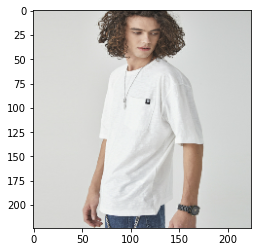

In [48]:
#tensor는 np.expand_dims가 tf.expand_dims사용 ->둘다 상관없다?
img = load_image(x_dict[test_id])
img_array = img.numpy()/255
plt.imshow(img_array)

In [49]:
def choose_top_class(pred_result,num) :
    category = minor_onehot.columns
    return sorted(zip(pred_result,category), reverse=True)[:num]

In [50]:
#이미지 id를 입력하면 이미지 사진, 예측결과, 예측태그, 실제 태그를 보여주는 것
def show_test_result(id,path_map,minor_map,model,top_category) :
    img = load_image(path_map[id])
    img_array = img.numpy()/255
    plt.title("real image")
    plt.imshow(img_array)
    img = tf.expand_dims(img, 0)
    model.predict(img)[0] #(1,41)형태로 나오므로 indexing 필수
    
    print(model.predict(img)[0])
    print("예측된 top 카테고리 : ",choose_top_class(model.predict(img)[0],top_category))
    print("실제 카테고리 : ",minor_map[id])

[3.6002821e-04 6.1339578e-03 1.0107187e-06 8.6853899e-05 1.3371491e-07
 1.3603889e-04 2.7238109e-06 1.3745567e-03 3.8519465e-07 4.5278506e-07
 1.0370192e-05 1.0268213e-06 2.1011288e-05 1.3120653e-03 8.7025901e-06
 5.4398997e-06 1.0491173e-02 5.7062634e-06 5.3037566e-01 5.1528691e-06
 4.7632949e-03 2.3543693e-05 4.6897441e-04 1.3989490e-05 3.9156526e-01
 1.0741919e-07 6.0494330e-08 1.0214105e-06 4.4079097e-05 2.8040736e-06
 3.4607595e-08 5.3782458e-04 1.5569544e-06 3.0888200e-06 9.8075798e-05
 7.1563120e-09 1.4282104e-04 5.1613048e-02 3.8073154e-04 7.3027181e-06]
예측된 top 카테고리 :  [(0.53037566, '미디 원피스'), (0.39156526, '셔츠/블라우스'), (0.051613048, '피케/카라 티셔츠')]
실제 카테고리 :  미디 원피스


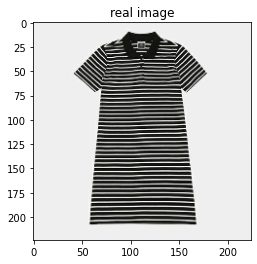

In [56]:
show_test_result(2814,x_dict,y_dict,new_model,3)

In [132]:
y_pred[7]

array([2.4057711e-34, 1.0007854e-24, 2.9868210e-19, 0.0000000e+00,
       0.0000000e+00, 1.5702073e-05, 5.1000725e-20, 1.0923741e-09,
       0.0000000e+00, 0.0000000e+00, 3.9310096e-38, 5.0310640e-22,
       9.6142056e-21, 2.7276814e-16, 8.3530619e-36, 0.0000000e+00,
       4.2202498e-14, 0.0000000e+00, 8.8470551e-22, 0.0000000e+00,
       0.0000000e+00, 1.3937794e-13, 4.8392521e-36, 1.0811516e-36,
       6.4163762e-28, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.4278641e-20, 4.9491110e-32, 1.1951419e-37, 0.0000000e+00,
       0.0000000e+00, 6.2010846e-19, 5.2206703e-38, 9.9997342e-01,
       1.0754383e-28, 1.1866569e-09, 5.5237401e-11, 0.0000000e+00,
       1.0789355e-05], dtype=float32)

In [127]:
y_test[2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [120]:
y_pred_proba = new_model.predict_proba(test_dataset)

ValueError: The `batch_size` argument must not be specified for the given input type. Received input: <BatchDataset shapes: (((None, 224, 224, 3), (None,)), (None, 41)), types: ((tf.float32, tf.string), tf.uint8)>, batch_size: 32

In [ ]:
# 적용 결과 생성된 태그 확인
#one-hot vector의 확률을 보여줘야 함
#one-hot vector에서 가장 높은 값 3개를 category화


모델 학습결과 저장

In [ ]:
#학습결과 저장
if not os.path.exists('weight_path/'):
    os.mkdir('weight_path/')
self.weight_save_path = os.path.join('weight_path/', self.name + "_weights.h5")

print('{:=^75}'.format('Saving weights to {}'.format(self.weight_save_path)))
self.model.save_weights(self.weight_save_path)
print('{:=^75}'.format('Saved weights'))

### 학습속도, 정확도 개선을 위한 수술

#### 데이터 준비과정의 문제

1. 이미지 url로 받지 말고, 그냥 파일시스템에서 받을까?  
->결과: 확실히 url로 받는 것 보다는 빠르다

2. 데이터를 Array가 아니라 다른 데이터포맷으로 넣으면 될까  
-> 가능한 데이터포맷 : tf dataset, pickle  
-> 방식 : path 리스트, one_hot list -> datasets에 저장 -> batch화 해서 불러오기

3. 배치 대신 통으로 올려서 학습하면?  
->x_data를 통으로 다 image로 바꾸자

In [ ]:
total_num = len(x_data)//2
x_data_half = np.array([resize(imread(file_name), (224, 224, 3)) for file_name in x_data[:total_num]])

In [40]:
y_data_half = y_data[:total_num]

4. 카테고리 선택의 문제  
-> 너무 세부적으로 분류하려 하지 말고, 중분류단위로 하는것도 고려  
-> 소분류 중에서도 숫자가 많은 것들만 골라서 학습하면 어떨까

#### 모델 선정의 문제

1. Pre-trained 모델에서 unfrozen 수 선택 문제  
-> =Transfer Learning 방식의 문제(Feature extraction vs Fine-tuning)  
-> Feature Extraction은 Dense만 Unfreeze, Fine-Tuning은 Layer도 Unfreeze  
->  결과 : Unfrozen이 적어지면 빨라지긴 함 근데 정확도랑은 trade-off일수도?  
->  feature extraction보다 finetuning의 성능이 월등히 좋았네요.

2. 모델을 좀 더 간단한 걸 써야되나?  
-> 훈련이 짧고 빠른 커스텀 모델을 사용해보자  
-> Model 이용 Functional Subclassing 대신 Sequential로 바로 정의

3. Pretrained 모델 중 가장 적절한 모델 선택  
![](https://miro.medium.com/max/875/1*BxQ4eGIJ63beLZ-IFujbIA.png)
-> 성능/Parameter 갯수의 타협 필요  
-> InceptionV3. Xception

#### 학습 과정에서의 문제

1. 배치 제네레이터의 코드의 문제  
ValueError: could not broadcast input array from shape (224,224,3) into shape (224,224)  
-> 이는 url호출과정에서의 문제인가 아님 파일 자체의 문제인가  
-> 결과 : 파일시스템에서는 잘 동작, url 호출과정의 문제인듯


2. 배치 생성시 CustomGenerator 대신  Keras.ImageDataGenerator 사용해보기
https://medium.com/daangn/%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%A7%8C%EC%9C%BC%EB%A1%9C-%EB%82%B4-%EC%A4%91%EA%B3%A0%EB%AC%BC%ED%92%88%EC%9D%98-%EC%B9%B4%ED%85%8C%EA%B3%A0%EB%A6%AC%EB%A5%BC-%EB%B6%84%EB%A5%98%ED%95%B4%EC%A4%80%EB%A9%B4-feat-keras-b86e5f286c71

3. 매우 간단한 모델임에도 불구하고 OOM이 뜬다. 해결하자  
-> memory profile를 이용한 메모리 소모 확인  
-> gc.collect() 을 이용한 메모리 정리

## CNN-RNN 이용

제공할 데이터

    이미지(필수)
    제품명(넣으면 정확도 급격히 상승할 듯?) -> 그러나 자연어처리 과정이 추가적으로 필요
    제품설명 (No. 애초에 설명을 달기 귀찮아서 자동태그를 쓰는건데, 앞뒤가 안 맞다)
    
참고 문서  
https://medium.com/mighty-data-science-bootcamp/번역-머신러닝을-활용한-제품-카테고리-분류하기-cd75f11d588a